In [2]:
import pandas as pd
import numpy as np

In [5]:
crime_df = pd.read_csv(r"/Users/eshaals/Downloads/BaAM-data-team/socio_data/chicago_crime_with_socio.csv")
business_df = pd.read_csv(r"/Users/eshaals/Downloads/BaAM-data-team/business_licenses_datasets/business_licenses.csv")
population_df = pd.read_csv(r"/Users/eshaals/Downloads/BaAM-data-team/population_datasets/Chicago_Population_Counts_Cleaned.csv")
homicides_df = pd.read_csv(r"/Users/eshaals/Downloads/BaAM-data-team/cleaned_data/Chicago_Homicides_Cleaned.csv")

In [6]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54989 entries, 0 to 54988
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 54989 non-null  object 
 1   LICENSE ID                         54989 non-null  int64  
 2   ACCOUNT NUMBER                     54989 non-null  int64  
 3   SITE NUMBER                        54989 non-null  int64  
 4   LEGAL NAME                         54989 non-null  object 
 5   DOING BUSINESS AS NAME             54868 non-null  object 
 6   ADDRESS                            54989 non-null  object 
 7   CITY                               54989 non-null  object 
 8   STATE                              54989 non-null  object 
 9   ZIP CODE                           54967 non-null  object 
 10  WARD                               50348 non-null  float64
 11  PRECINCT                           50188 non-null  flo

In [8]:
print(business_df)

                     ID  LICENSE ID  ACCOUNT NUMBER  SITE NUMBER  \
0      2563584-20260916     3020538           56526            5   
1      1883320-20260516     2967415          325535            2   
2      3031207-20251016     3031217          385123            3   
3      1992079-20250901     3033354          315199           10   
4      2428081-20250901     3033848          375961            3   
...                 ...         ...             ...          ...   
54984          3031210-     3031210          511745            2   
54985          2689935-     3002403          458760            7   
54986          2988552-     2993521          510270            1   
54987          2967141-     2967141          395576            1   
54988          2987890-     2987890          509231            1   

                                             LEGAL NAME  \
0                                   APPLE COMPUTER, INC   
1                               ASHLAND COMMERCIAL, LLC   
2     

In [5]:
# === Feature Engineering ===

## 1) Crime Socio-Demographics Features (already partly cleaned)
# Drop records without community area name
crime_df_clean = crime_df.dropna(subset=["COMMUNITY_AREA_NAME"])

# Group by community area and average the socio-demographic values
socio_features = crime_df_clean.groupby("COMMUNITY_AREA_NAME").agg({
    "PERCENT_OF_HOUSING_CROWDED": "mean",
    "PERCENT_HOUSEHOLDS_BELOW_POVERTY": "mean",
    "PERCENT_AGED_16+_UNEMPLOYED": "mean",
    "PERCENT_AGED_25+_WITHOUT_HIGH_SCHOOL_DIPLOMA": "mean",
    "PER_CAPITA_INCOME": "mean",
    "HARDSHIP_INDEX": "mean"
}).reset_index()

# Rename for clarity
socio_features.columns = [
    "Community Area", "Pct_Housing_Crowded", "Pct_Below_Poverty",
    "Pct_Unemployed", "Pct_Without_HS_Diploma",
    "Per_Capita_Income", "Hardship_Index"
]

In [6]:
## 2) Population-based Features
# Calculate new features from population_df
population_df["Pct_Under_18"] = population_df["Population - Age 0-17"] / population_df["Population - Total"] * 100
population_df["Pct_Seniors_65plus"] = population_df["Population - Age 65+"] / population_df["Population - Total"] * 100
population_df["Gender_Ratio_Female_Male"] = population_df["Population - Female"] / population_df["Population - Male"]
population_df["Pct_Black_Non_Latinx"] = population_df["Population - Black Non-Latinx"] / population_df["Population - Total"] * 100
population_df["Pct_Latinx"] = population_df["Population - Latinx"] / population_df["Population - Total"] * 100

# Calculate Dependency Ratio
working_age = population_df["Population - Age 18+"] - population_df["Population - Age 65+"]
dependent = population_df["Population - Age 0-17"] + population_df["Population - Age 65+"]
population_df["Dependency_Ratio"] = dependent / working_age

# Population density
population_df["Pop_Density"] = population_df["Population - Total"] / 2.5  # if land area unavailable, use a placeholder

# Select engineered features
pop_features = population_df[[
    "community", "Population - Total", "Pct_Under_18", "Pct_Seniors_65plus", "Gender_Ratio_Female_Male",
    "Pct_Black_Non_Latinx", "Pct_Latinx", "Dependency_Ratio", "Pop_Density"
]].rename(columns={"community": "Community Area"})

In [10]:
## 3. Business Density Features
# === Filter active business licenses ===
business_df = business_df.copy()
business_df = business_df[
    (business_df["LICENSE TERM EXPIRATION DATE"] >= "2022-01-01") &
    (business_df["COMMUNITY AREA"].notna())
]

# Drop duplicates
business_df = business_df.drop_duplicates(subset=["LICENSE ID"])

# Clean license descriptions
business_df["LICENSE DESCRIPTION"] = business_df["LICENSE DESCRIPTION"].str.lower()

# Add business category flags
business_df["is_retail"] = business_df["LICENSE DESCRIPTION"].str.contains("retail")
business_df["is_food"] = business_df["LICENSE DESCRIPTION"].str.contains("restaurant|food|catering|grocery")

# Group by community area
business_features = business_df.groupby("COMMUNITY AREA").agg({
    "LICENSE ID": "count",
    "is_retail": "sum",
    "is_food": "sum",
    "LICENSE CODE": pd.Series.nunique
}).reset_index()

# Rename columns
business_features.columns = [
    "Community_Area_Code", "Active_Business_Count",
    "Retail_Business_Count", "Restaurant_Count", "License_Type_Diversity"
]

# merge with area name
area_map = crime_df[["COMMUNITY_AREA", "COMMUNITY_AREA_NAME"]].dropna().drop_duplicates()
business_features = pd.merge(business_features, area_map,
                             left_on="Community_Area_Code", right_on="COMMUNITY_AREA", how="left")

business_features = business_features.rename(columns={"COMMUNITY_AREA_NAME": "Community Area"})

In [11]:
# === Merge All Features ===

# Merge socio + population
merged_df = pd.merge(socio_features, pop_features, on="Community Area", how="left")

# Merge business features
final_df = pd.merge(merged_df, business_features[[
    "Community Area", "Active_Business_Count",
    "Retail_Business_Count", "Restaurant_Count",
    "License_Type_Diversity"
]], on="Community Area", how="left")

# Business per 1000 residents
final_df["Business_Per_1000"] = final_df["Active_Business_Count"] / final_df["Population - Total"] * 1000


In [14]:
final_df.to_csv("sociodemographic_features_by_area.csv", index=False)

In [4]:
final_df = pd.read_csv(r"/Users/eshaals/Downloads/BaAM-data-team/socio_data/sprint 6&7/sociodemographic_features_by_area.csv")
final_df

,Community Area,Pct_Housing_Crowded,Pct_Below_Poverty,Pct_Unemployed,Pct_Without_HS_Diploma,Per_Capita_Income,Hardship_Index
0,Albany Park,11.3,19.2,10.0,32.9,21323.0,53.0
1,Archer Heights,8.5,14.1,16.5,35.9,16134.0,67.0
2,Armour Square,5.7,40.1,16.7,34.5,16148.0,82.0
3,Ashburn,4.0,10.4,11.7,17.7,23482.0,37.0
4,Auburn Gresham,4.0,27.6,28.3,18.5,15528.0,74.0
...,...,...,...,...,...,...,...
73,West Lawn,5.8,14.9,9.6,33.6,16907.0,56.0
74,West Pullman,3.3,25.9,19.4,20.5,16563.0,62.0
75,West Ridge,7.8,17.2,8.8,20.8,23040.0,46.0
76,West Town,2.3,14.7,6.6,12.9,43198.0,10.0


In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Community Area          78 non-null     object 
 1   Pct_Housing_Crowded     78 non-null     float64
 2   Pct_Below_Poverty       78 non-null     float64
 3   Pct_Unemployed          78 non-null     float64
 4   Pct_Without_HS_Diploma  78 non-null     float64
 5   Per_Capita_Income       78 non-null     float64
 6   Hardship_Index          77 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.4+ KB


In [12]:
final_df = final_df.drop(columns=[
    'Population - Total',
    'Pct_Under_18',
    'Pct_Seniors_65plus',
    'Gender_Ratio_Female_Male',
    'Pct_Black_Non_Latinx',
    'Pct_Latinx',
    'Dependency_Ratio',
    'Pop_Density',
    'Active_Business_Count',
    'Retail_Business_Count',
    'Restaurant_Count',
    'License_Type_Diversity',
    'Business_Per_1000'
])


In [13]:
final_df

,Community Area,Pct_Housing_Crowded,Pct_Below_Poverty,Pct_Unemployed,Pct_Without_HS_Diploma,Per_Capita_Income,Hardship_Index
0,Albany Park,11.3,19.2,10.0,32.9,21323.0,53.0
1,Archer Heights,8.5,14.1,16.5,35.9,16134.0,67.0
2,Armour Square,5.7,40.1,16.7,34.5,16148.0,82.0
3,Ashburn,4.0,10.4,11.7,17.7,23482.0,37.0
4,Auburn Gresham,4.0,27.6,28.3,18.5,15528.0,74.0
...,...,...,...,...,...,...,...
73,West Lawn,5.8,14.9,9.6,33.6,16907.0,56.0
74,West Pullman,3.3,25.9,19.4,20.5,16563.0,62.0
75,West Ridge,7.8,17.2,8.8,20.8,23040.0,46.0
76,West Town,2.3,14.7,6.6,12.9,43198.0,10.0


## feature selection techniques

Correlation Heatmaps (for numeric variables)

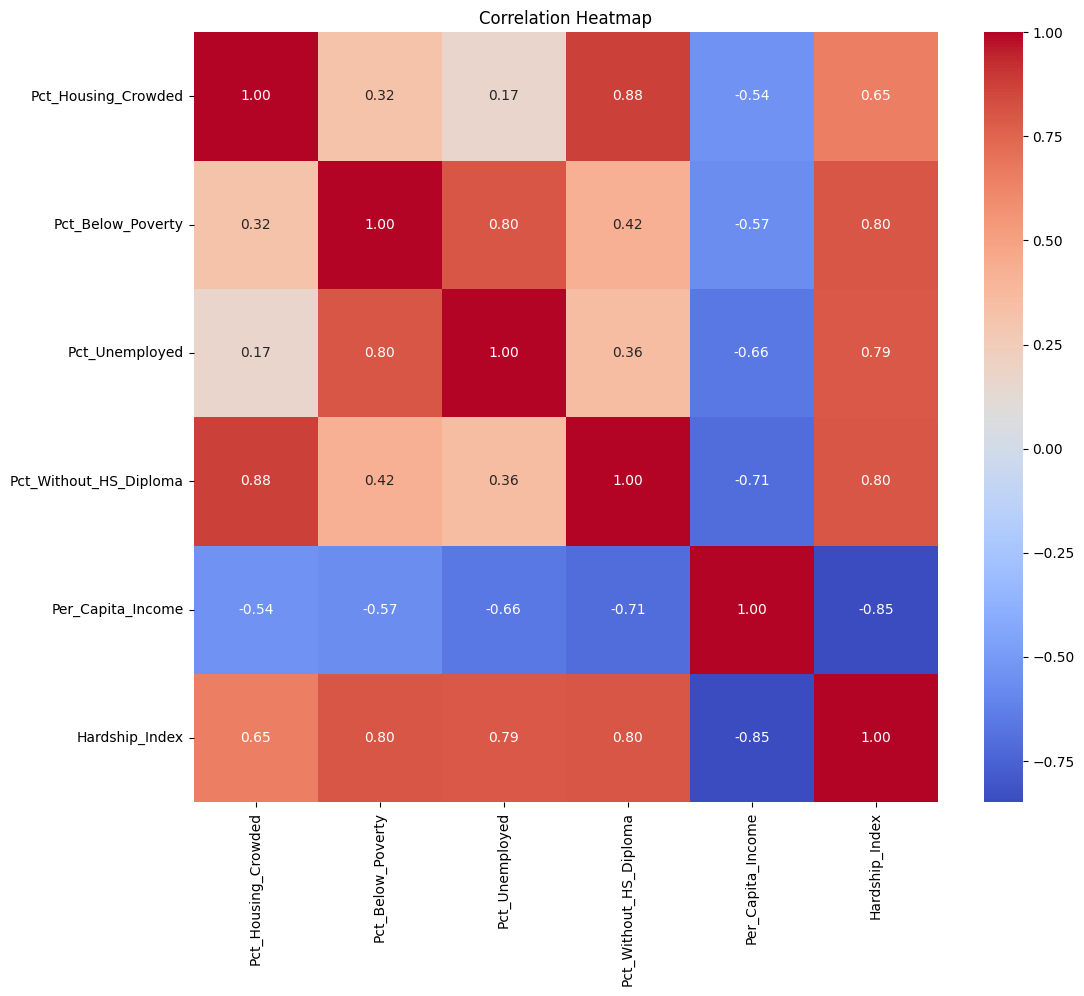

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = final_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

distribution of individual variables

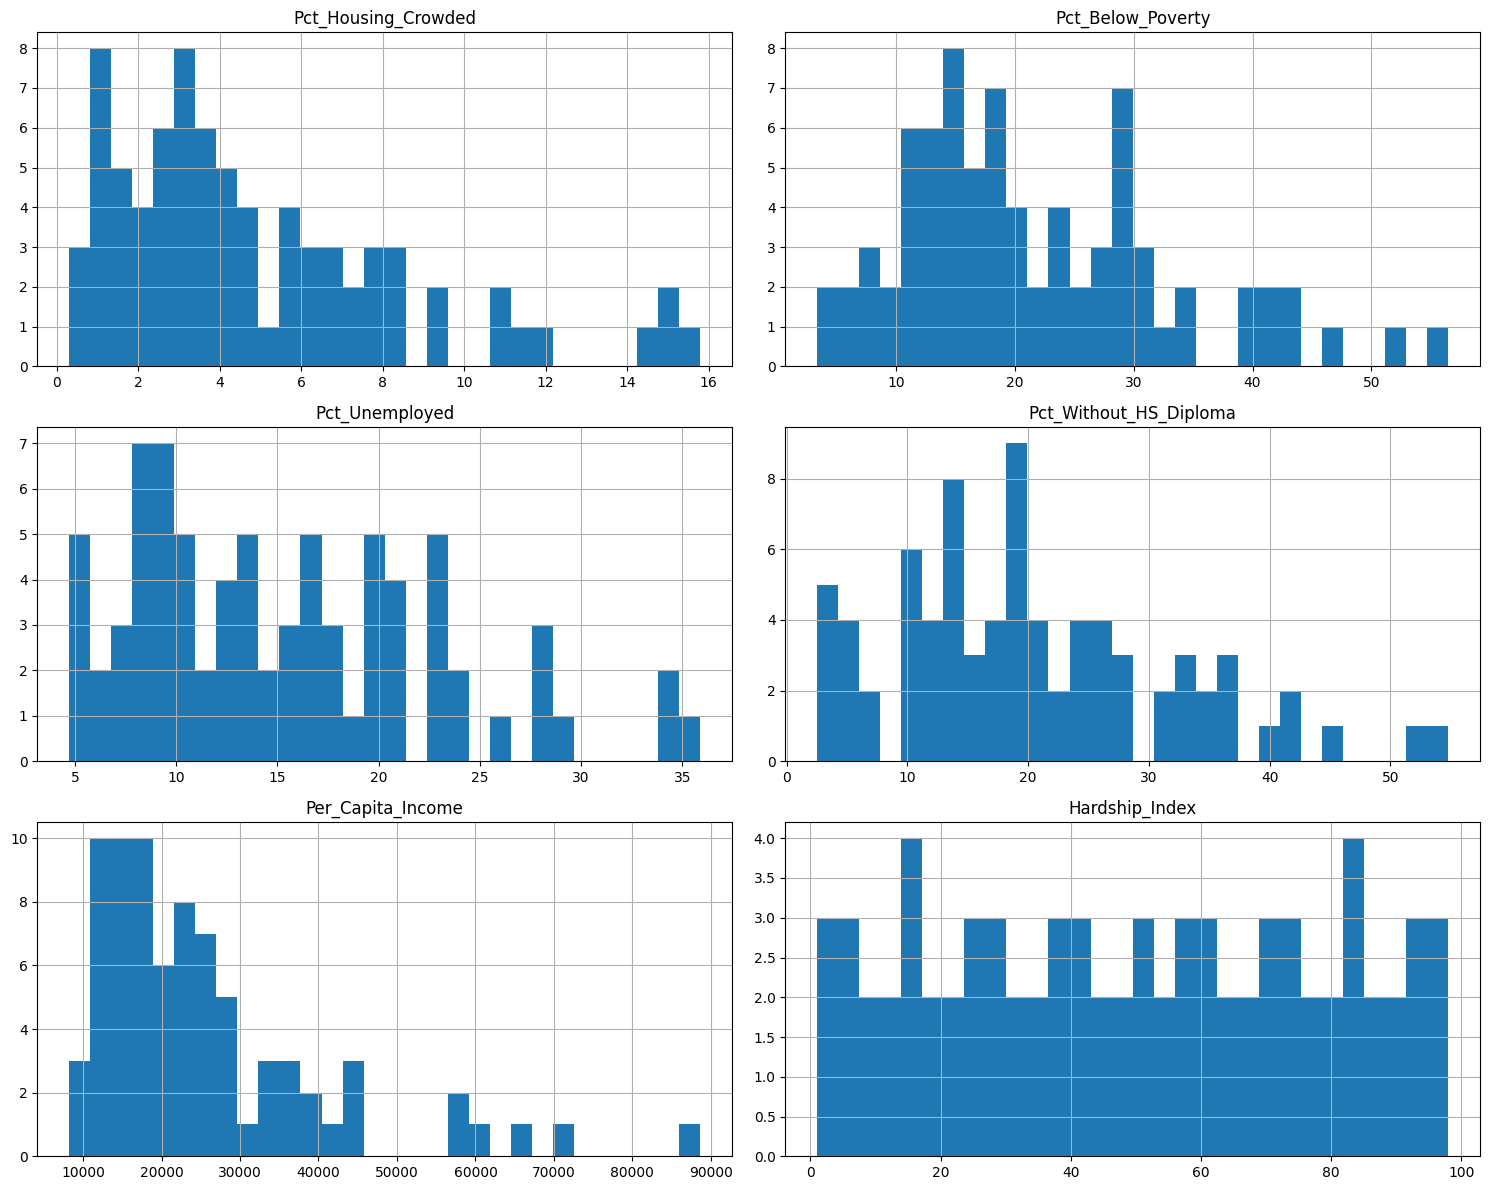

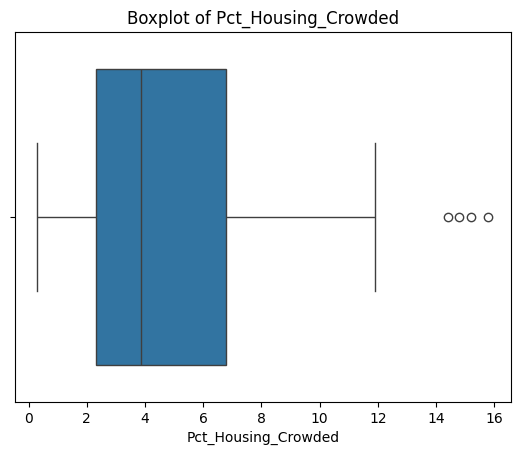

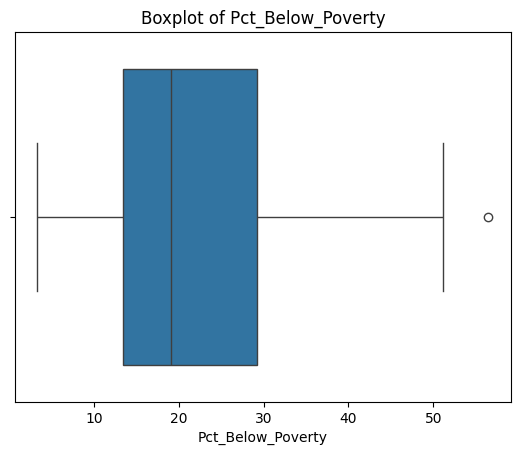

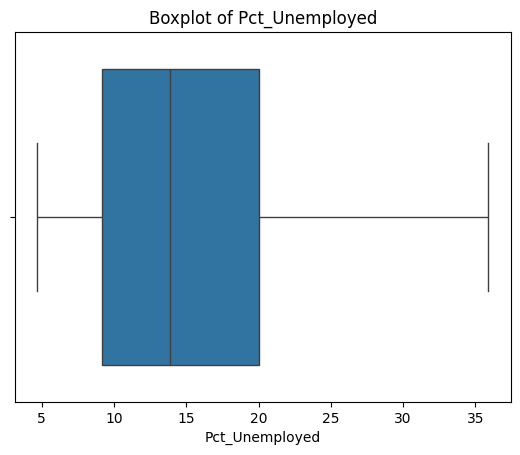

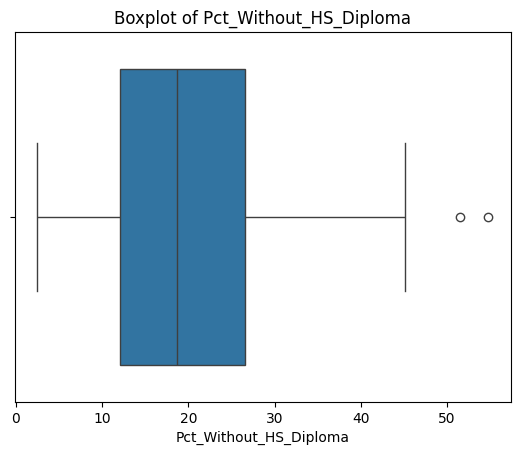

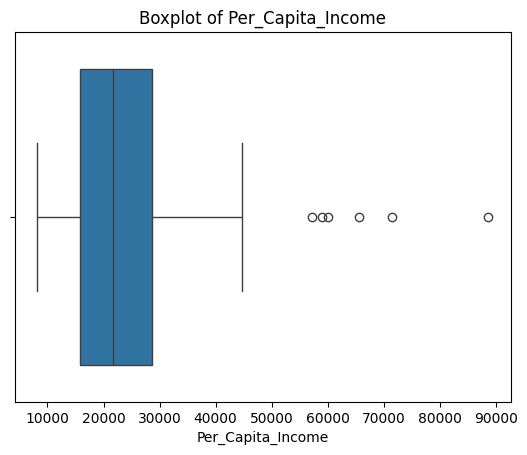

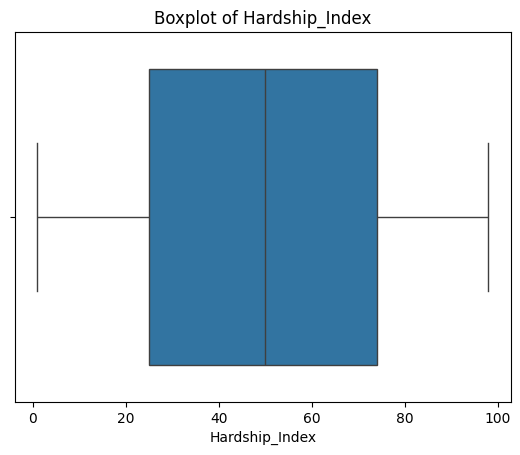

In [7]:
# For histograms
final_df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

# For boxplots (better for spotting outliers)
import matplotlib.pyplot as plt
for col in final_df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=final_df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


document features

In [13]:
# === Document Features ===
feature_dict = pd.DataFrame({
    "Feature": final_df.columns,
    "Description": [
        "Name of community area",
        "% Housing crowded", "% Below poverty", "% Unemployed",
        "% without high school", "Per capita income", "Hardship index",
        "Population", "% Under 18", "% 65+", "Female to male ratio",
        "% Black Non-Latinx", "% Latinx", "Age dependency ratio", "Population density",
        "Active business licenses", "# of retail businesses", "# of restaurants",
        "Unique license types", "Businesses per 1000 residents"
    ],
    "Data Type": ["str"] + ["float"] * (len(final_df.columns) - 1)
})

feature_dict.to_csv("feature_documentation.csv", index=False)